In [17]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'soil-image-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3213740%2F5584573%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240816%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240816T160545Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D45731c4e324e608703af94f90ceac82584f673eb62eaa341f9a822d279a7416781f9cab12604f033fef35001ceb74f886b1829649927da9c66303c1add9125453e3bd1ca005fb0abf331737fa050c08388f0ea4374e2ae5a924effe2051354abf0aeec27c1b9a224a5d9d8fd84daa5585e034bd8e9a835561935c1ec85f85b6511e13f726f8206c69833e45f7f79e0981fd0590f50beab3f270bd5cc1f164d4824732ece45b733196c38b0d836b7b5e76336f17603dcf9170781f49f80cf092810cd5a6d1c1150ed31abda25eba3fc4545c215d0cd47aaee852ec51dba6b0321f9f96d61743a7bb3deacfdce290e4b40d32012f2232b8f01f60749c94fe26c62'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 60302324 bytes downloaded
Downloaded and uncompressed: soil-image-classification
Data source import complete.


In [18]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/soil-image-classification/test/Black Soil/Black_35.jpg
/kaggle/input/soil-image-classification/test/Black Soil/Black_11.jpg
/kaggle/input/soil-image-classification/test/Black Soil/Copy of images433.jpg
/kaggle/input/soil-image-classification/test/Black Soil/Copy of images432.jpg
/kaggle/input/soil-image-classification/test/Black Soil/Black_17.jpg
/kaggle/input/soil-image-classification/test/Black Soil/images434.jpg
/kaggle/input/soil-image-classification/test/Black Soil/images400.jpg
/kaggle/input/soil-image-classification/test/Black Soil/Black_21.jpg
/kaggle/input/soil-image-classification/test/Black Soil/Copy of images431.jpg
/kaggle/input/soil-image-classification/test/Black Soil/Copy of images398(1).jpg
/kaggle/input/soil-image-classification/test/Black Soil/Copy of images413(1).jpg
/kaggle/input/soil-image-classification/test/Black Soil/Black_6.jpg
/kaggle/input/soil-image-classification/test/Black Soil/images396.jpg
/kaggle/input/soil-image-classification/test/Black

In [19]:
import re
import os
import cv2
import time
import shutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping


In [20]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    horizontal_flip= True,
    rotation_range= 10,
    shear_range= 0.2,
    height_shift_range= 0.1,
    width_shift_range= 0.1,
    validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/soil-image-classification/train_data',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    '/kaggle/input/soil-image-classification/train_data',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/soil-image-classification/test',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)




Found 277 images belonging to 4 classes.
Found 66 images belonging to 4 classes.
Found 158 images belonging to 4 classes.


In [26]:
num_conv=2
num_dense=1
layer_size=32
num_epochs=14

In [22]:
model= Sequential()

model.add(Conv2D(layer_size, (3, 3), input_shape=(256, 256, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

for _ in range(num_conv-1):
    model.add(Conv2D(layer_size, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

for _ in range(num_dense):
    model.add(Dense(layer_size))
    model.add(Activation('relu'))

model.add(Dense(4))
model.add(Activation('softmax'))

In [23]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
model.fit(
    train_generator,
    epochs=num_epochs,
    validation_data=validation_generator
)

Epoch 1/14
9/9 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.7622 - loss: 0.4985 - val_accuracy: 0.7424 - val_loss: 0.6973
Epoch 2/14
9/9 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.8294 - loss: 0.4471 - val_accuracy: 0.7879 - val_loss: 0.5870
Epoch 3/14
9/9 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.8443 - loss: 0.4032 - val_accuracy: 0.8485 - val_loss: 0.5615
Epoch 4/14
9/9 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.8249 - loss: 0.4522 - val_accuracy: 0.8182 - val_loss: 0.5117
Epoch 5/14
9/9 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.8479 - loss: 0.3805 - val_accuracy: 0.8030 - val_loss: 0.4856
Epoch 6/14
9/9 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.9092 - loss: 0.3083 - val_accuracy: 0.8485 - val_loss: 0.4198
Epoch 7/14
9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.8741 - loss: 0.3368 - val_accuracy: 0.7727 - val_loss: 0.4431
Epoch 8/14
9/9 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.8629 - loss: 0.3429 - val_accuracy: 0.7879 - val_loss: 0.6999
Epoch 9/

In [28]:
model.save('soilmodel.h5')

In [37]:
import numpy as np
import matplotlib.pyplot as plt

predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1, verbose=1)
true_labels = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

def plot_all_images(generator, predictions, true_labels, class_labels):
    generator.reset()
    batch_size = generator.batch_size
    num_batches = len(true_labels) // batch_size + 1

    num_images = len(true_labels)

    # Determine the number of rows and columns for the grid
    grid_size = int(np.ceil(np.sqrt(num_images)))

    plt.figure(figsize=(grid_size * 2, grid_size * 2))

    image_count = 0

    for batch_index in range(num_batches):
        image_batch, label_batch = next(generator)
        batch_predictions = predictions[batch_index * batch_size: (batch_index + 1) * batch_size]
        batch_true_labels = true_labels[batch_index * batch_size: (batch_index + 1) * batch_size]

        for i in range(len(image_batch)):
            if image_count >= num_images:
                break

            image = image_batch[i]
            true_label = batch_true_labels[i]
            predicted_class = np.argmax(batch_predictions[i])

            plt.subplot(grid_size, grid_size, image_count + 1)
            plt.imshow(image)
            plt.title(f"T: {class_labels[true_label]}\nP: {class_labels[predicted_class]}")
            plt.axis('off')

            image_count += 1

    plt.tight_layout()
    plt.show()

plot_all_images(test_generator, predictions, true_labels, class_labels)


Output hidden; open in https://colab.research.google.com to view.

In [40]:
from sklearn.metrics import accuracy_score
predicted_labels = np.argmax(predictions, axis=1)
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.6329


In [86]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

soil_model = load_model('soilmodel.h5')
def make_prediction(image_fp):
    im = cv2.imread(image_fp)
    im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.imshow(im_rgb)
    plt.axis('off')
    plt.show()


    img = image.load_img(image_fp, target_size=(256, 256))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0

    img_batch = np.expand_dims(img_array, axis=0)

    class_names = ["Alluvial soil", "Clay soil", "Black soil", "Red soil"]

    predictions = soil_model.predict(img_batch)
    predicted_class_index = np.argmax(predictions)
    predicted_value = class_names[predicted_class_index]

    print(f"The predicted class is {predicted_value}")
    return predicted_value

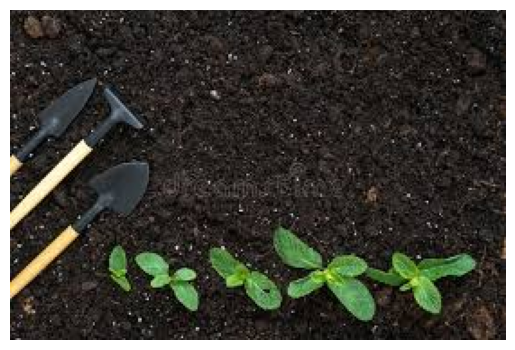

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
The predicted class is Black soil


'Black soil'

In [87]:
input_image="Black_45.jpg"
make_prediction(input_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 865ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step


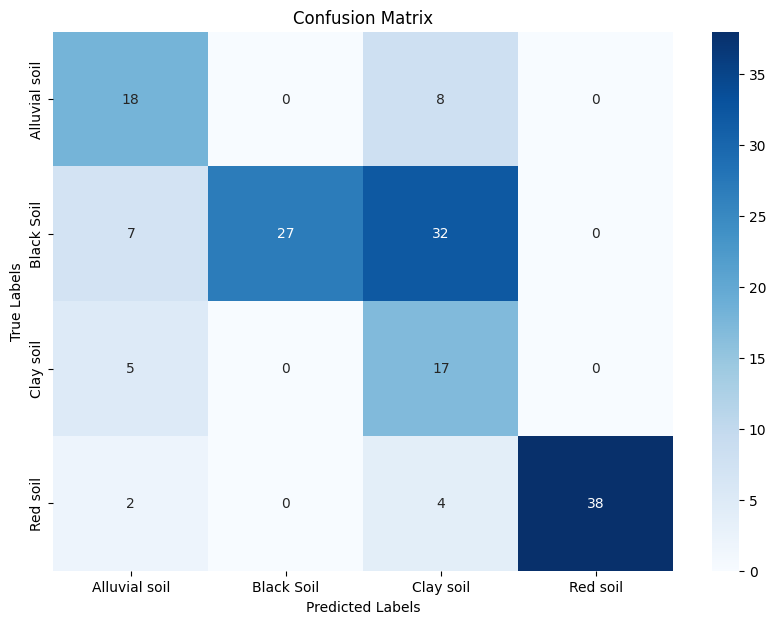

In [50]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

true_labels_list = []
predicted_labels_list = []

for _ in range(len(test_generator)):

    images, true_labels_batch = next(test_generator)

    if true_labels_batch.ndim > 1:
        true_labels_batch = np.argmax(true_labels_batch, axis=1)

    predictions = model.predict(images)
    predicted_classes_batch = np.argmax(predictions, axis=1)

    true_labels_list.extend(true_labels_batch)
    predicted_labels_list.extend(predicted_classes_batch)

true_labels = np.array(true_labels_list)
predicted_labels = np.array(predicted_labels_list)

class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_labels, predicted_labels, labels=range(len(class_labels)))

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [63]:
import requests
import pandas as pd

file_id = '1ZRdah45NeU_ARL4lbPBCzFrGG5PAYRK0'

download_url = f'https://drive.google.com/uc?id={file_id}&export=download'

response = requests.get(download_url)

with open('new_crop.csv', 'wb') as f:
    f.write(response.content)

df = pd.read_csv('new_crop.csv')

In [64]:
df.head()

,soil,N,P,K,temperature,humidity,ph,rainfall,label
0,clay,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,clay,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,clay,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,clay,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,clay,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [65]:
df.shape

(2200, 9)

In [66]:
missing_values=df.isnull().sum()
print(missing_values)

soil           0
N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64


Text(0.5, 1.0, 'Crop Types')

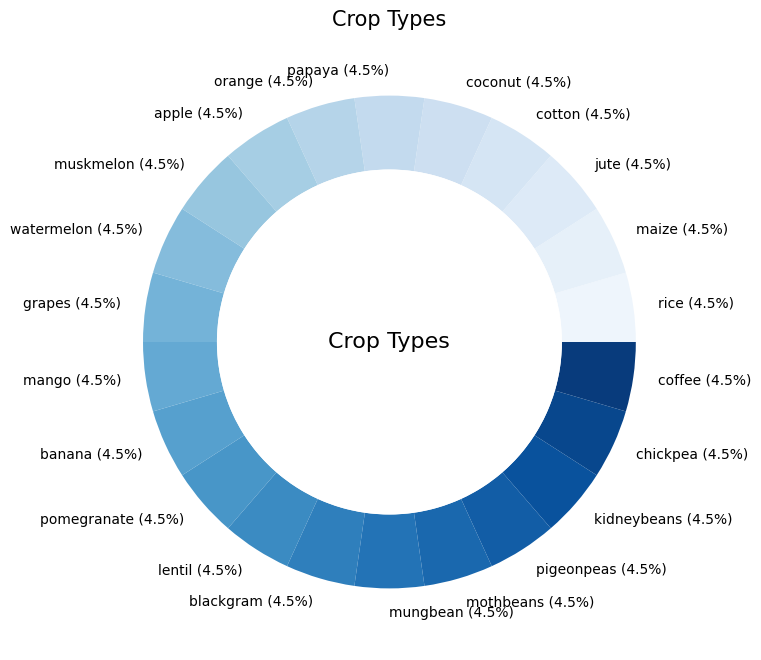

In [91]:
fig, ax = plt.subplots(figsize=(9, 8))
total = df['label'].value_counts().sum()
colors = sns.color_palette('Blues', len(df['label'].unique()))
sorted_labels = df['label'].value_counts().index
# Only display the percentage
labels_with_percent = [f'{label} ({size/total:.1%})' for label, size in zip(sorted_labels, df['label'].value_counts())]
wedges, texts, autotexts = ax.pie(df['label'].value_counts(), labels=labels_with_percent, colors=colors, wedgeprops=dict(width=0.3), autopct='')
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)
ax.text(0, 0, 'Crop Types', ha='center', va='center', fontsize=16)
ax.set_title('Crop Types', fontsize=15)


Text(0.5, 1.0, 'Soil Types')

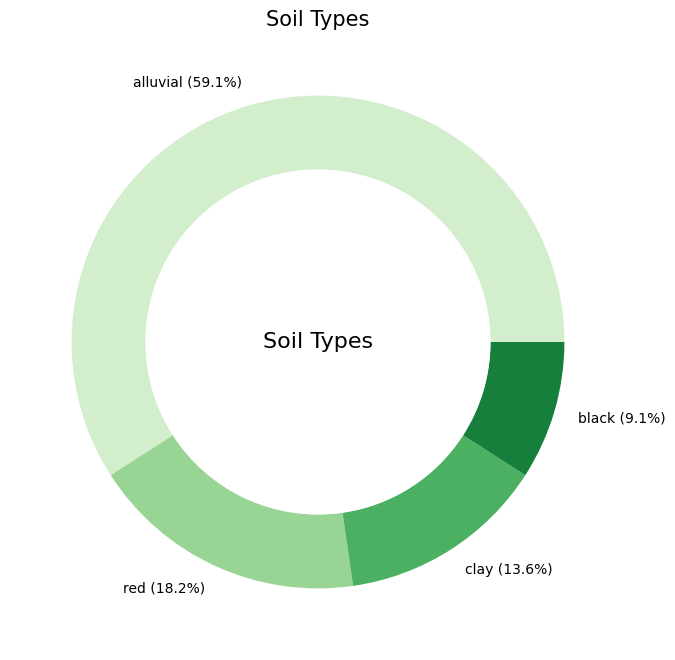

In [93]:
fig, ax = plt.subplots(figsize=(9, 8))
total = df['soil'].value_counts().sum()
colors = sns.color_palette('Greens', len(df['soil'].unique()))
sorted_labels = df['soil'].value_counts().index
labels_with_percent = [f'{label} ({size/total:.1%})' for label, size in zip(sorted_labels, df['soil'].value_counts())]
wedges, texts, autotexts = ax.pie(df['soil'].value_counts(), labels=labels_with_percent, colors=colors, wedgeprops=dict(width=0.3), autopct='')
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)
ax.text(0, 0, 'Soil Types', ha='center', va='center', fontsize=16)
ax.set_title('Soil Types', fontsize=15)


In [68]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
encoded_columns = encoder.fit_transform(df[['soil', 'label']])
encoded_col_names = encoder.get_feature_names_out(['soil', 'label'])

df_encoded = pd.DataFrame(encoded_columns, columns=encoded_col_names)

df_final = pd.concat([df.drop(['soil', 'label'], axis=1), df_encoded], axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [69]:
df_final.head()

,N,P,K,temperature,humidity,ph,rainfall,soil_alluvial,soil_black,soil_clay,...,label_mango,label_mothbeans,label_mungbean,label_muskmelon,label_orange,label_papaya,label_pigeonpeas,label_pomegranate,label_rice,label_watermelon
0,90,42,43,20.879744,82.002744,6.502985,202.935536,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,85,58,41,21.770462,80.319644,7.038096,226.655537,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,60,55,44,23.004459,82.320763,7.840207,263.964248,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,74,35,40,26.491096,80.158363,6.980401,242.864034,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,78,42,42,20.130175,81.604873,7.628473,262.717340,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


from matplotlib import pyplot as plt
_df_16['N'].plot(kind='hist', bins=20, title='N')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_17['P'].plot(kind='hist', bins=20, title='P')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_18['K'].plot(kind='hist', bins=20, title='K')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_19['temperature'].plot(kind='hist', bins=20, title='temperature')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_20.plot(kind='scatter', x='N', y='P', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_21.plot(kind='scatter', x='P', y='K', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_22.plot(kind='scatter', x='K', y='temperature', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_23.plot(kind='scatter', x='temperature', y='humidity', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['soil_alluvial']
  ys = series['N']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_24.sort_values('soil_alluvial', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('soil_alluvial')
_ = plt.ylabel('N')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['soil_alluvial']
  ys = series['P']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_25.sort_values('soil_alluvial', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('soil_alluvial')
_ = plt.ylabel('P')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['soil_alluvial']
  ys = series['K']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_26.sort_values('soil_alluvial', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('soil_alluvial')
_ = plt.ylabel('K')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['soil_alluvial']
  ys = series['temperature']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_27.sort_values('soil_alluvial', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('soil_alluvial')
_ = plt.ylabel('temperature')

from matplotlib import pyplot as plt
_df_28['N'].plot(kind='line', figsize=(8, 4), title='N')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_29['P'].plot(kind='line', figsize=(8, 4), title='P')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_30['K'].plot(kind='line', figsize=(8, 4), title='K')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_31['temperature'].plot(kind='line', figsize=(8, 4), title='temperature')
plt.gca().spines[['top', 'right']].set_visible(False)

In [70]:
df_final.columns

Index(['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall',
       'soil_alluvial', 'soil_black', 'soil_clay', 'soil_red', 'label_apple',
       'label_banana', 'label_blackgram', 'label_chickpea', 'label_coconut',
       'label_coffee', 'label_cotton', 'label_grapes', 'label_jute',
       'label_kidneybeans', 'label_lentil', 'label_maize', 'label_mango',
       'label_mothbeans', 'label_mungbean', 'label_muskmelon', 'label_orange',
       'label_papaya', 'label_pigeonpeas', 'label_pomegranate', 'label_rice',
       'label_watermelon'],
      dtype='object')

In [71]:
from sklearn.model_selection import train_test_split
X=df_final.iloc[:,:11].values
y=df_final.iloc[:,11:].values

In [72]:
print(y.shape)

(2200, 22)


In [80]:
print(X.shape)

(2200, 11)


In [73]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [74]:
print(y_test)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [75]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train[:, :7] = scaler.fit_transform(X_train[:,:7])
X_test[:,:7] = scaler.transform(X_test[:,:7])

In [81]:
print(X_train.shape)

(1760, 11)


In [82]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

model = Sequential()

model.add(Dense(units=64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=16, activation='relu'))

model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.1077 - loss: 3.0086 - val_accuracy: 0.3386 - val_loss: 2.6003
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3438 - loss: 2.4664 - val_accuracy: 0.6091 - val_loss: 1.7874
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6265 - loss: 1.6569 - val_accuracy: 0.8114 - val_loss: 1.0187
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8485 - loss: 0.8830 - val_accuracy: 0.9205 - val_loss: 0.5045
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9327 - loss: 0.4233 - val_accuracy: 0.9227 - val_loss: 0.3140
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9439 - loss: 0.2456 - val_accuracy: 0.9568 - val_loss: 0.1990
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9601 - loss: 0.1645 - val_accuracy: 0.9591 - val_loss: 0.1654
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9714 - loss: 0.1248 - val_accuracy: 0.9659 - val_loss:

In [84]:
model.save('cropmodel.keras')

In [85]:
index_to_crop = {
    0: 'apple',
    1: 'banana',
    2: 'blackgram',
    3: 'chickpea',
    4: 'coconut',
    5: 'coffee',
    6: 'cotton',
    7: 'grapes',
    8: 'jute',
    9: 'kidneybeans',
    10: 'lentil',
    11: 'maize',
    12: 'mango',
    13: 'mothbeans',
    14: 'mungbean',
    15: 'muskmelon',
    16: 'orange',
    17: 'papaya',
    18: 'pigeonpeas',
    19: 'pomegranate',
    20: 'rice',
    21: 'watermelon'
}

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Please enter the following features:
Enter image name:Black_45.jpg


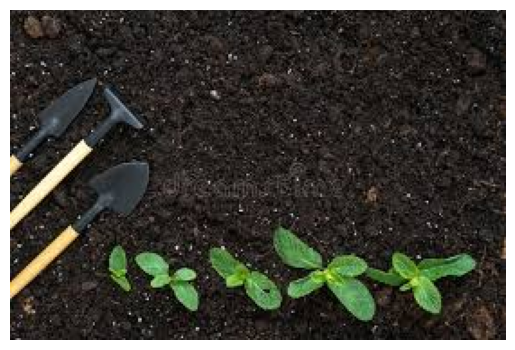

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
The predicted class is Black soil
Nitrogen (numeric value): 27
Phosphorous (numeric value): 76
Potassium (numeric value): 83
Temperature (numeric value): 19.1
Humidity (numeric value): 14.9
pH (numeric value): 6.2
Rainfall (numeric value): 89.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Predicted crop: apple


In [90]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import load_model


scaler = StandardScaler()
scaler.fit(X_train)

crop_model = load_model('cropmodel.keras')
#soil_model = load_model('soilmodel.h5')
def encode_soil_type(soil_type):

    soil_alluvial = 0
    soil_black = 0
    soil_clay = 0
    soil_red = 0


    if soil_type == "Alluvial soil" or soil_type == "Alluvial Soil":
      soil_alluvial = 1
    elif soil_type == "Black soil" or soil_type == "Black Soil":
      soil_black = 1
    elif soil_type == "Clay soil" or soil_type == "Clay Soil":
      soil_clay = 1
    elif soil_type == "Red soil" or soil_type == "Red Soil":
      soil_red = 1
    return soil_alluvial, soil_black, soil_clay, soil_red

print("Please enter the following features:")
input_image1=input("Enter image name:")
predicted_value=make_prediction(input_image1)
soil_type_input = predicted_value
soil_alluvial, soil_black, soil_clay, soil_red = encode_soil_type(soil_type_input)


nitrogen = float(input("Nitrogen (numeric value): "))
phosphorous = float(input("Phosphorous (numeric value): "))
potassium = float(input("Potassium (numeric value): "))
temp = float(input("Temperature (numeric value): "))
humidity = float(input("Humidity (numeric value): "))
ph = float(input("pH (numeric value): "))
rainfall = float(input("Rainfall (numeric value): "))


new_data = np.array([[nitrogen, phosphorous, potassium, temp, humidity, ph, rainfall, soil_alluvial, soil_black, soil_clay, soil_red]])


new_data_preprocessed = scaler.transform(new_data)


predictions = crop_model.predict(new_data_preprocessed)
predicted_class_index = np.argmax(predictions, axis=1)[0]

predicted_crop = index_to_crop.get(predicted_class_index, 'Unknown')

print(f'Predicted crop: {predicted_crop}')

In [92]:
from sklearn.preprocessing import StandardScaler
import joblib

scaler = StandardScaler()
scaler.fit(X_train)  # Fit on your training data
joblib.dump(scaler, 'scaler.pkl')  # Save the fitted scaler to a file


['scaler.pkl']